### Model Paramater Inference

With our model setup we are ready to infer some values for our model parameters. It is sufficient to calculate the unnormalized posterior so we can write out the joint probability of the likelihood and the prior $P({\alpha,\beta})P({\Theta}|{\alpha,\beta}) P(Data|{\Theta})$ and use that to minimize the negative log likelihood of the parameters.

Tensorflow requires you to specify this explicitly, as shown below:

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import matplotlib.pyplot as plt


# load the raw data generated from the previous step here. This is a proxy for the actual data
observations = [0.5866870270537066, 0.7423740001882816, 0.686161716106754, 0.6460388097685779, 
                0.8528624255950258, 0.6472059517780163, 0.9486623670757193, 0.932087988712534]


def joint_logprob(observations, alpha_prior, beta_prior):  
  # Joint logProbability function for both random variables and observations.
  rv_observed = tfd.Gamma(concentration=alpha_prior, rate=beta_prior, name='model')  
  rv_alpha = tfd.Uniform(low=0.0, high=100.0, name = 'alpha')
  rv_beta  = tfd.Uniform(low=0.0, high=100.0, name = 'beta')

  y_model = observations
  sum_log_prob = rv_alpha.log_prob(alpha_prior) + rv_beta.log_prob(beta_prior) +\
                  tf.reduce_sum(rv_observed.log_prob(observations))

  return sum_log_prob


# Create state to hold updated `step_size`.
step_size = tf.get_variable(
    name='step_size',
    initializer=0.06,
    use_resource=True,  # For TFE compatibility.
    trainable=False)

# Initialize the HMC transition kernel.
unnormalized_target_posterior= lambda *args: joint_logprob(observations, *args)
num_results = int(12000)
num_burnin_steps = int(8000)
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=unnormalized_target_posterior,
    num_leapfrog_steps=3,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(
      num_adaptation_steps=int(num_burnin_steps * 0.8)))

# Run the chain (with burn-in).
[alpha_samples,beta_samples], kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[1.,1.],
    kernel=hmc)

# Initialize all constructed variables.
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
  init_op.run()
  alpha_samples_, beta_samples_, kernel_results_ = sess.run([alpha_samples, beta_samples, kernel_results])


print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(
    alpha_samples_.mean(), alpha_samples_.std(), kernel_results_.is_accepted.mean()))
print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(
    beta_samples_.mean(), beta_samples_.std(), kernel_results_.is_accepted.mean()))



We plot the sampling chain to make sure the MCMC random walk was successful. 
We also plot the priors for  alpha and beta.


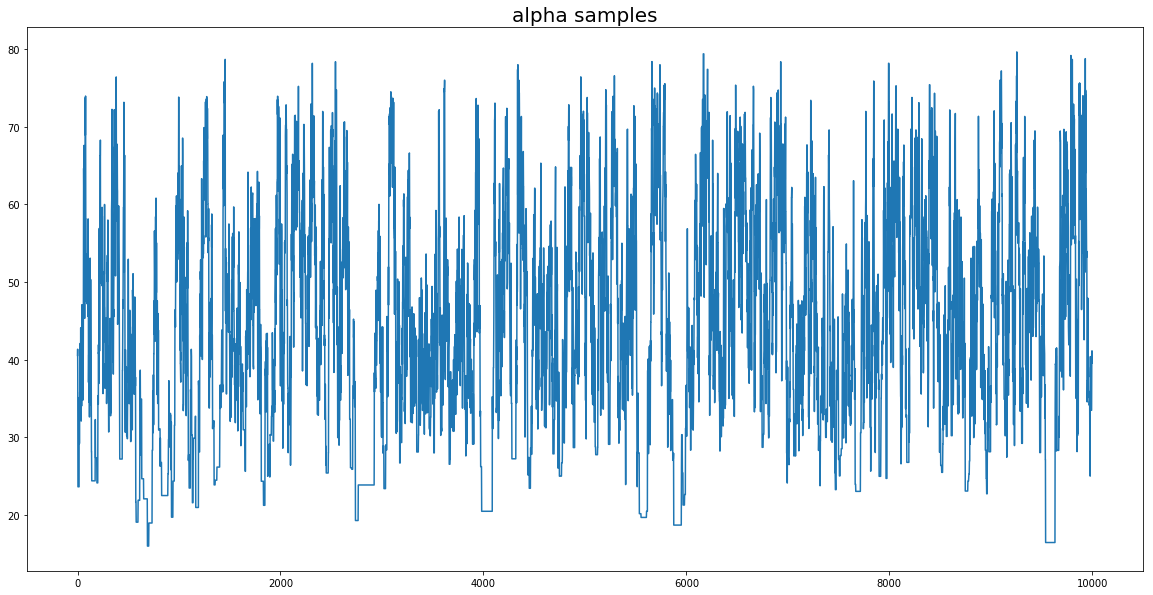

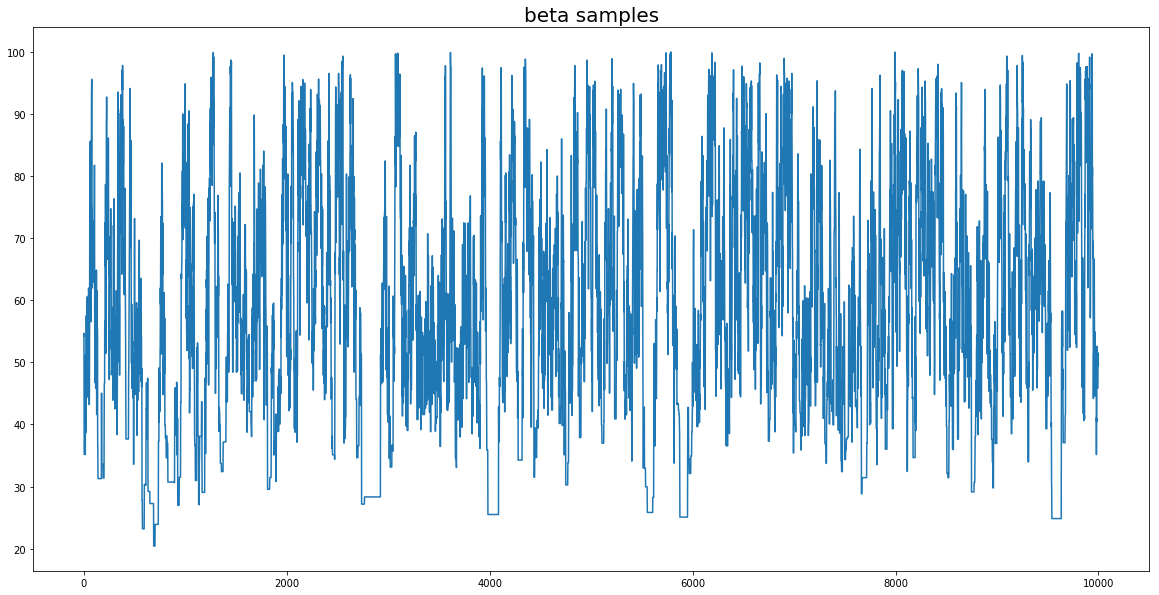

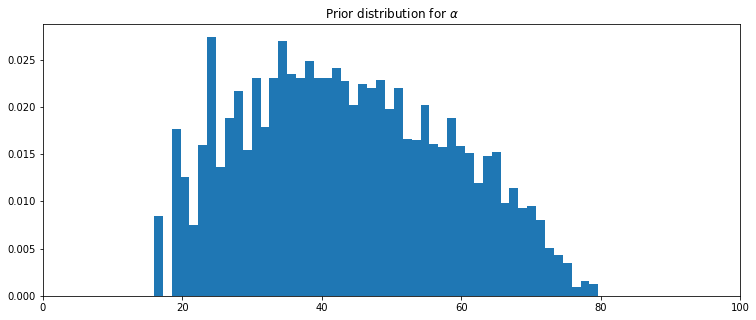

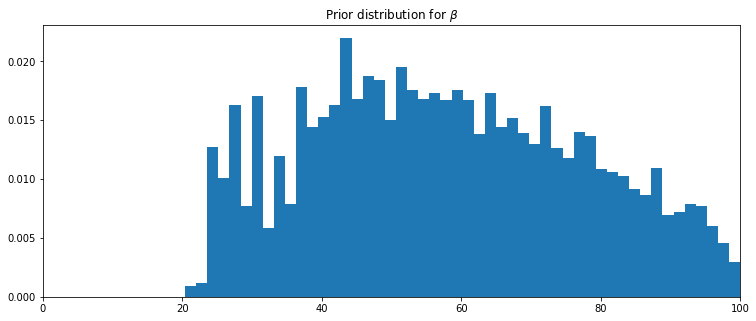

In [0]:
import matplotlib.pyplot as plt

# plotting the mcmc chains
plt.figure(figsize=(20,10))
plt.plot(np.arange(num_results), alpha_samples_)
plt.title('alpha samples',fontsize=20)

plt.figure(figsize=(20,10))
plt.plot(np.arange(num_results), beta_samples_)
plt.title('beta samples',fontsize=20)

plt.figure(figsize=[12.5, 5])
plt.hist(alpha_samples_, bins=50, density=True, histtype="stepfilled")
plt.title(r"Prior distribution for $\alpha$")
plt.xlim(0, 100);

plt.figure(figsize=[12.5, 5])
plt.hist(beta_samples_, bins=50, density=True, histtype="stepfilled")
plt.title(r"Prior distribution for $\beta$")
plt.xlim(0, 100);

## Parameter prediction





We plot 100 Gamma distributions using the sampled alpha and beta values. Also overlayed on top  is the Gamma distribtion using the mean values of alpha and beta. The mean distribution agrees  well with the sampled distributions, so we use the mean values to for predictions

Finally we sample from the mean distribitution in the range {mean - 2*stddev, mean+2*stddev} and plot the predicted accelerometer samples. A system enggineer can assess what the permissible range of theta should be in order to trade-off precision v/s recall. 



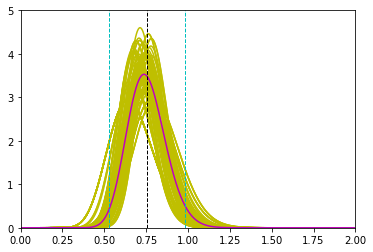

In [0]:
import scipy.stats as stats 
import math

x = np.linspace (0, 2, 2000) 

a=alpha_samples_.mean()
b=beta_samples_.mean()


for n in range(100):
  y = stats.gamma.pdf(x, a=alpha_samples_[n], scale=1/beta_samples_[n])
  plt.plot(x, y, "y-", label=(r'$Posterior Gamma$')) 

rv_y_mean = stats.gamma.pdf(x, a=a, scale=1/b)
plt.plot(x, rv_y_mean, "y-", color='m', label=(r'$Posterior Gamma$')) 
plt.axvline(a/b, color='k', linestyle='dashed', linewidth=1)

mean = a/b
s = math.sqrt(a)/b
lo_threshold = mean - 2*s
hi_threshold = mean + 2*s

plt.axvline(mean + 2*s, color='c', linestyle='dashed', linewidth=1)
plt.axvline(mean - 2*s, color='c', linestyle='dashed', linewidth=1)

plt.ylim([0,5])
plt.xlim([0,2])


plt.show()

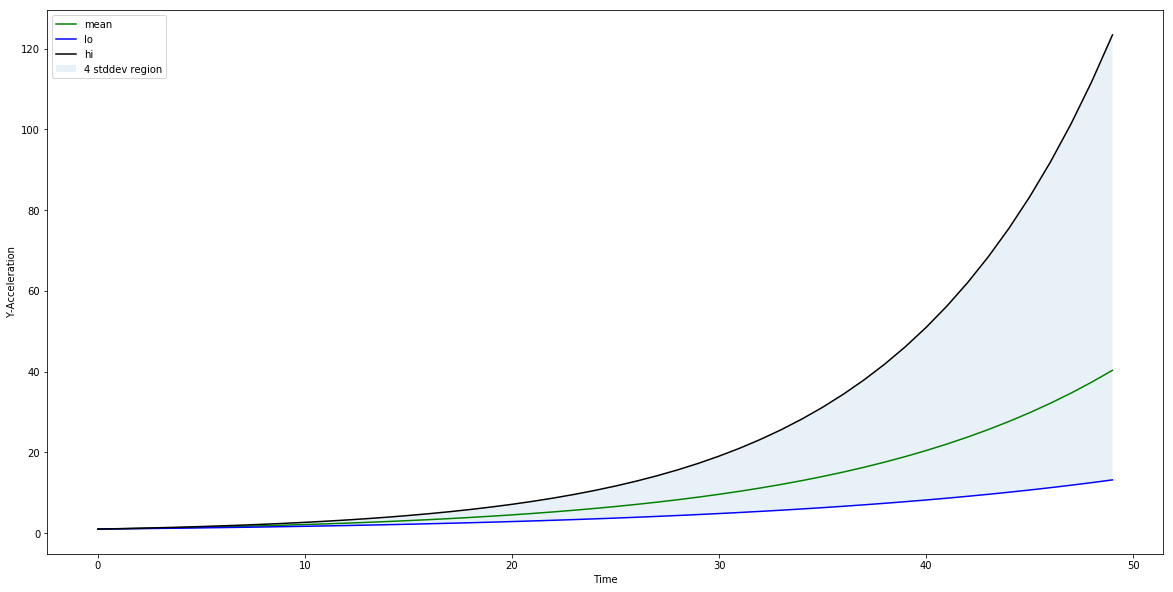

In [0]:
# we predict the posterior values of the parameter ${\Theta} from the mean values of alpha and theta

# divide by 10 before plotting

thetas = np.arange(mean - 2*s, mean + 2*s, 0.01)
time = np.arange(0,50) # 1 sec sample, 50 samples per second
hi_y = np.exp((hi_threshold/10.)*time)
lo_y = np.exp((lo_threshold/10.)*time)

# lower_per = np.percentile(y_samples,2.5, axis = 1)
# upper_per = np.percentile(y_samples,97.5, axis = 1)

plt.figure(figsize =(20,10))

plt.plot(time, np.exp((mean/10.)*time), 'g', label = 'mean')
plt.plot(time, lo_y, 'b', label = 'lo')
plt.plot(time, hi_y, 'k', label = 'hi')

# plt.plot(t,y,'kx', label = 'Data')

plt.fill_between(time, lo_y, hi_y, label = '4 stddev region', alpha = 0.1)
plt.xlabel('Time')
plt.ylabel('Y-Acceleration')

# plt.hlines(0.05, np.min(time), np.max(time), linestyles = '--', label = 'threshold')

plt.legend()